# HYBRID-RECOMMENDER BASED ON COSINE AND MF

In [ ]:
!pip install scikit-surprise

In [ ]:
## importing necessaries libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#**Hybrid Recommender**

A hybrid recommender system is a combination of multiple recommendation techniques or approaches to provide more accurate and diverse recommendations. It combines the strengths of different recommendation methods to overcome their individual limitations and enhance the overall recommendation quality.

Combining cosine similarity and matrix factorization is a common approach in building a hybrid recommender system for movie recommendations. Here's how each of these techniques can contribute to the hybrid model.


In [ ]:
# loading the dataset
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

# data preprocessing
# merge datasets
movie_ratings = pd.merge(ratings, movies, on='movieId')

# content-Based Filtering
# extract features using movie genres
tfidf = TfidfVectorizer(stop_words='english')
movies['genres'] = movies['genres'].fillna('')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# calculate similarity scores
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# collaborative Filtering
# load data for Surprise library
reader = Reader()
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# train SVD algorithm
algo = SVD()
cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

# hybridization
def hybrid_recommendations(userId, movie_title):
    # get movieId based on movie title
    movie_id = movies[movies['title'] == movie_title]['movieId'].values[0]

    # get indices of similar movies based on content-based filtering
    idx = movies[movies['movieId'] == movie_id].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Exclude the movie itself
    movie_indices = [i[0] for i in sim_scores]

    # get collaborative filtering recommendations
    movie_ratings['estimated_rating'] = movie_ratings.apply(lambda x: algo.predict(userId, x['movieId']).est, axis=1)
    collab_recs = movie_ratings[movie_ratings['userId'] == userId].sort_values(by='estimated_rating', ascending=False)['title'][:10]

    # combine recommendations from both approaches
    hybrid_recs = movies.iloc[movie_indices]['title'].tolist() + collab_recs.tolist()
    hybrid_recs = list(set(hybrid_recs))

    return hybrid_recs

# evaluation
# split data into training and testing sets
train_data, test_data = train_test_split(ratings, test_size=0.2)

# train the model
trainset = data.build_full_trainset()
algo.fit(trainset)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8706  0.8738  0.8755  0.8706  0.8757  0.8732  0.0022  
Fit time          2.46    1.86    2.83    3.33    4.80    3.06    0.99    
Test time         0.48    0.22    0.56    0.53    0.52    0.46    0.12    


In [ ]:
import pickle

In [ ]:
with open('similarity.pkl', 'wb') as file:
    pickle.dump(cosine_sim, file)

In [ ]:
with open('matrix.pkl', 'wb') as file:
    pickle.dump(algo, file)

In [ ]:
with open('movies.pkl', 'wb') as file:
    pickle.dump(movies, file)

In [ ]:
# make predictions on the test data
test_predictions = test_data.apply(lambda x: algo.predict(x['userId'], x['movieId']).est, axis=1)

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(test_data['rating'], test_predictions))
print("RMSE:", rmse)

RMSE: 0.6432018325727452


In [ ]:
# prediction for user id 1
userId = 1
movie_title = "Toy Story (1995)"
recommendations = hybrid_recommendations(userId, movie_title)
print("Hybrid Recommendations for User", userId, "based on", movie_title)
for i, movie in enumerate(recommendations, 1):
    print(i, "-", movie)

Hybrid Recommendations for User 1 based on Toy Story (1995)
1 - Indiana Jones and the Last Crusade (1989)
2 - Monsters, Inc. (2001)
3 - Tale of Despereaux, The (2008)
4 - Shrek the Third (2007)
5 - Asterix and the Vikings (Astérix et les Vikings) (2006)
6 - Fugitive, The (1993)
7 - Adventures of Rocky and Bullwinkle, The (2000)
8 - Toy Story 2 (1999)
9 - Princess Bride, The (1987)
10 - Usual Suspects, The (1995)
11 - Reservoir Dogs (1992)
12 - Green Mile, The (1999)
13 - Star Wars: Episode IV - A New Hope (1977)
14 - Antz (1998)
15 - American History X (1998)
16 - Star Wars: Episode V - The Empire Strikes Back (1980)
17 - Road Warrior, The (Mad Max 2) (1981)
18 - Wild, The (2006)
19 - Emperor's New Groove, The (2000)
20 - Turbo (2013)


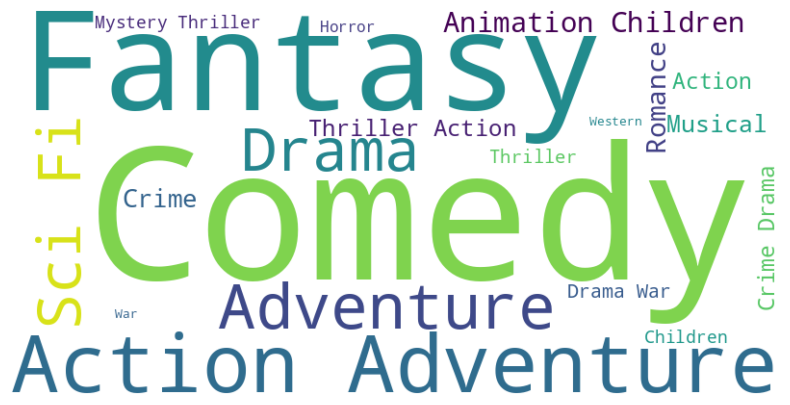

In [ ]:
# load datasets
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

# user_id = "id"
user_id = 1

# filter movies rated highly by the user
user_ratings = ratings[ratings['userId'] == user_id]
high_rated_movies = user_ratings[user_ratings['rating'] >= 4]

# merge with movies dataset to get genres
high_rated_movies_with_genres = pd.merge(high_rated_movies, movies, on='movieId')

# concatenate all genres into a single string
genres_text = ' '.join(high_rated_movies_with_genres['genres'])

# generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(genres_text)

# display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


<ipython-input-16-04b822cc0501>:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(movie_stats['count'], movie_stats['mean'], alpha=0.5, cmap="cool")


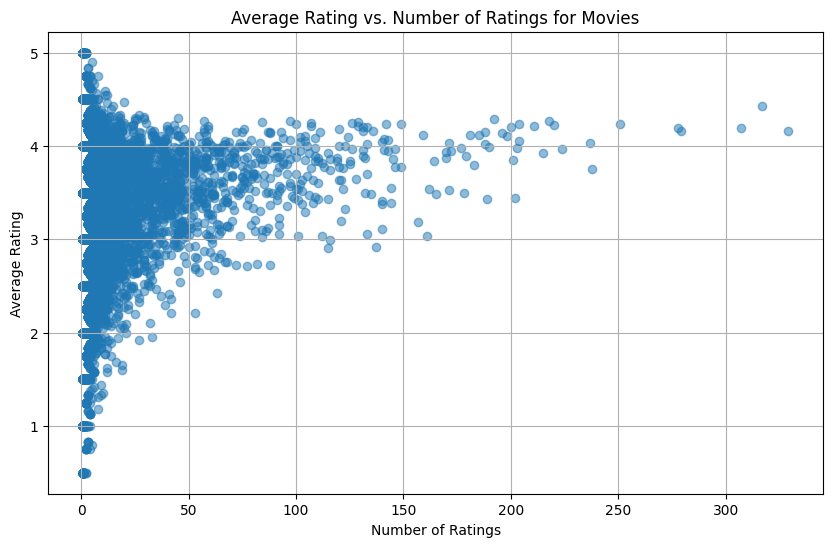

In [ ]:
## scatter plot for avg ratings vs no of ratings

# load datasets
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

# calculate average rating and number of ratings for each movie
movie_stats = ratings.groupby('movieId').agg({'rating': ['mean', 'count']})
movie_stats.columns = movie_stats.columns.droplevel()

# merge with movies dataset to get movie titles
movie_stats = pd.merge(movie_stats, movies[['movieId', 'title']], on='movieId')

# plot scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(movie_stats['count'], movie_stats['mean'], alpha=0.5, cmap="cool")
plt.title('Average Rating vs. Number of Ratings for Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

In [ ]:
import seaborn as sns

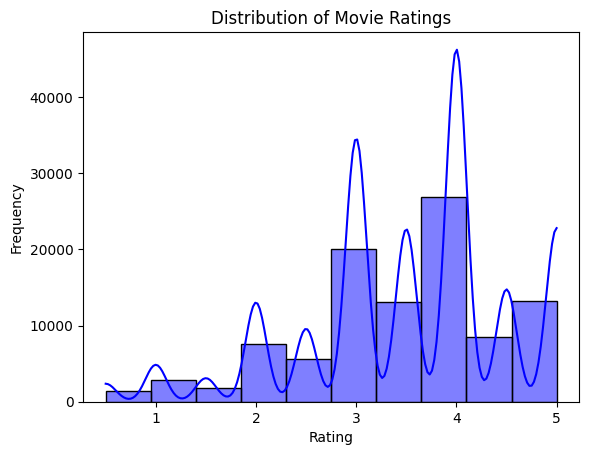

In [ ]:
# load MovieLens dataset
ratings_df = pd.read_csv('ratings.csv')

# plot distribution of ratings
sns.histplot(ratings_df['rating'], kde=True, bins=10, color='blue')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Ratings')
plt.show()

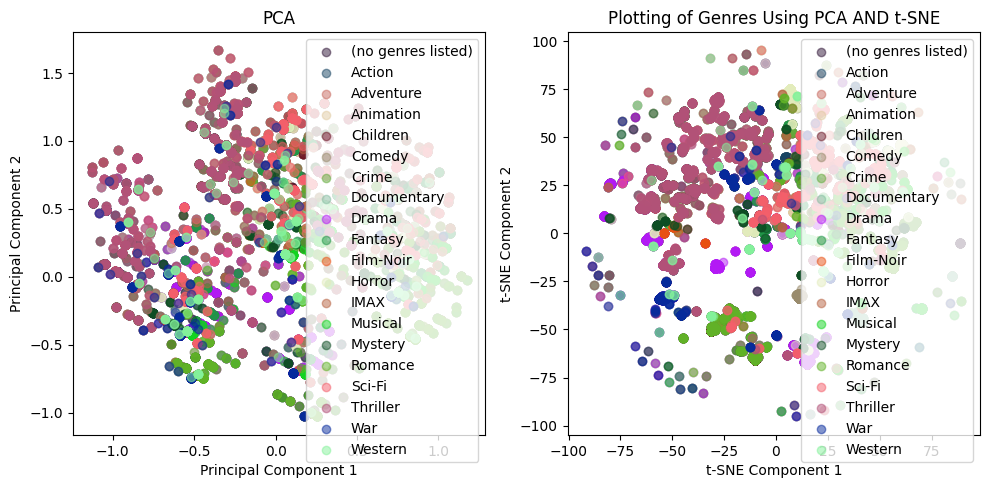

In [ ]:
# load datasets
movies = pd.read_csv("movies.csv")

# extract features for dimensionality reduction
# For simplicity, we'll use movie genres as features
genres = movies['genres'].str.get_dummies(sep='|')

# assigning unique colors to each genre
genre_colors = np.random.rand(genres.shape[1], 3)

# perform PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(genres)

# perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(genres)

# plotting PCA results with genre colors
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for i in range(genres.shape[1]):
    plt.scatter(pca_result[genres.iloc[:, i] == 1, 0], pca_result[genres.iloc[:, i] == 1, 1], alpha=0.5, label=genres.columns[i], c=[genre_colors[i]])
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# plotting t-SNE results with genre colors
plt.subplot(1, 2, 2)
for i in range(genres.shape[1]):
    plt.scatter(tsne_result[genres.iloc[:, i] == 1, 0], tsne_result[genres.iloc[:, i] == 1, 1], alpha=0.5, label=genres.columns[i], c=[genre_colors[i]])
plt.title('t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

plt.title("Plotting of Genres Using PCA AND t-SNE")
plt.tight_layout()
plt.show()


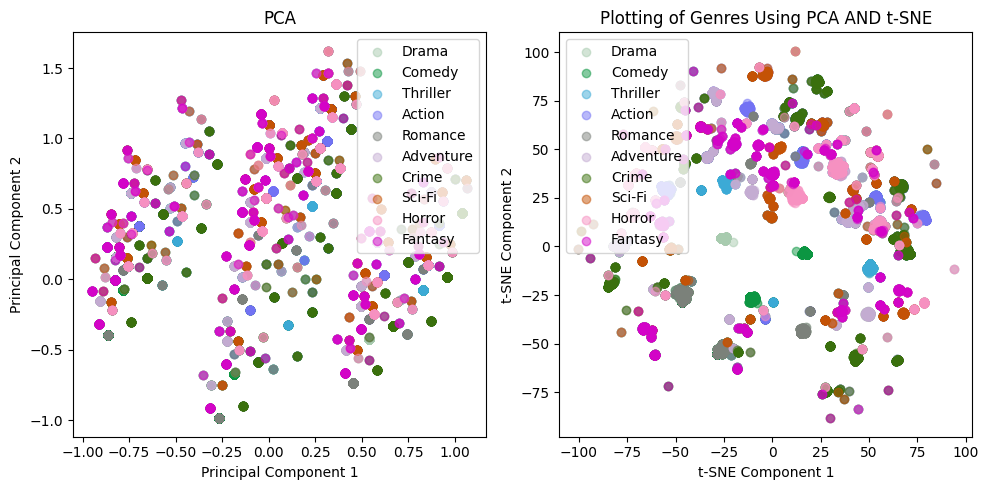

In [ ]:
movies = pd.read_csv("movies.csv")

# extract features for dimensionality reduction
# for simplicity, we'll use only the five most important genres

genres = movies['genres'].str.get_dummies(sep='|')
top_genres = genres.sum().nlargest(10).index
genres = genres[top_genres]

# assign unique colors to each genre
genre_colors = np.random.rand(genres.shape[1], 3)  # generate random RGB colors for each genre

# perform PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(genres)

# perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(genres)

# plotting PCA results with genre colors
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for i in range(genres.shape[1]):
    plt.scatter(pca_result[genres.iloc[:, i] == 1, 0], pca_result[genres.iloc[:, i] == 1, 1], alpha=0.5, label=top_genres[i], c=[genre_colors[i]])
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# plotting t-SNE results with genre colors
plt.subplot(1, 2, 2)
for i in range(genres.shape[1]):
    plt.scatter(tsne_result[genres.iloc[:, i] == 1, 0], tsne_result[genres.iloc[:, i] == 1, 1], alpha=0.5, label=top_genres[i], c=[genre_colors[i]])
plt.title('t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

plt.title("Plotting of Genres Using PCA AND t-SNE")
plt.tight_layout()
plt.show()
